


## Problem Setup
This example demonstrates a multi-agent deep deterministic policy gradient (MADDPG) approach to a competitive environment where chasers aim to catch evaders. Each group of agents (chasers and evaders) has its own policy and value networks, trained either independently or in a mixed cooperative-competitive setting. It serves as our control when we try and integrate prospect theory into the policy gradient, seeing if we can get different results than the reward graphs below. Code is based from [https://pytorch.org/rl/0.6/tutorials/multiagent_competitive_ddpg.html]

## Clear Problem Statement
Train two chaser agents to minimize the evader’s cumulative reward while simultaneously training the evader agent to maximize its own cumulative reward. The environment runs for a fixed number of steps, and training can be halted for certain agents at a chosen iteration.

## Mathematical Formulation
- **Agent Policies**: $\pi_i(\mathbf{o_i}; \theta_i)$ map observations $\mathbf{o_i}$ to continuous actions.
- **Value Function**: $Q_i(\mathbf{o}, \mathbf{a}; \phi_i)$ estimates future return given all agents’ actions $\mathbf{a}$ and observations $\mathbf{o}$.
- **Loss Functions**: DDPG losses incorporate actor and critic objectives, ensuring that each agent maximizes expected returns while considering centralized training and decentralized execution.
- **Updates**: Soft updates are performed on target networks with \(\tau\) for both the policy and value functions.

## Data Requirements
- Episodes of agent interactions, collected with exploration strategies (e.g., Gaussian noise).
- Replay buffers per group for sampled training batches containing states, actions, rewards, and next states.

## Success Metrics
- Mean episode reward for each group (chasers and evaders), typically measured and plotted over training iterations.
- Convergence or stabilization of the reward signal, indicating improved policy performance.


### **Approach: Importing Required Libraries**
This section imports essential modules for implementing MADDPG:  
- **PyTorch** for deep learning operations.  
- **`torchrl` modules** for multi-agent reinforcement learning, including environments, policies, collectors, and replay buffers.  
- **`tensordict`** for structured tensor operations.  
- **Matplotlib** for visualization.  
- **`tqdm`** for progress tracking.

In [56]:
import copy
import tempfile

import torch

from matplotlib import pyplot as plt
from tensordict import TensorDictBase

from tensordict.nn import TensorDictModule, TensorDictSequential
from torch import multiprocessing

from torchrl.collectors import SyncDataCollector
from torchrl.data import LazyMemmapStorage, RandomSampler, ReplayBuffer

from torchrl.envs import (
    check_env_specs,
    ExplorationType,
    PettingZooEnv,
    RewardSum,
    set_exploration_type,
    TransformedEnv,
    VmasEnv,
)

from torchrl.modules import (
    AdditiveGaussianModule,
    MultiAgentMLP,
    ProbabilisticActor,
    TanhDelta,
)

from torchrl.objectives import DDPGLoss, SoftUpdate, ValueEstimators

from torchrl.record import CSVLogger, PixelRenderTransform, VideoRecorder

from tqdm import tqdm

try:
    is_sphinx = __sphinx_build__
except NameError:
    is_sphinx = False

### **Approach: Environment Setup & Hyperparameters**
- **Seed & Device**: Sets the random seed for reproducibility and selects the appropriate device (GPU if available, otherwise CPU).  
- **Sampling**: Defines frames collected per batch (`1,000`), total iterations (`50`), and total frames (`50,000`).  
- **Training Control**: Stops evader training at `iteration_when_stop_training_evaders = 25`.  
- **Replay Buffer**: Stores up to `1M` frames for experience replay.  
- **Training Parameters**:  
  - **Optimization**: `100` updates per iteration, batch size of `128`.  
  - **Learning Rate**: `3e-4`, gradient clipping at `1.0`.  
- **DDPG-Specific**: Uses discount factor (`γ = 0.99`) and soft update parameter (`τ = 0.005`).

In [77]:
# Seed
seed = 0
torch.manual_seed(seed)

# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)

# Sampling
frames_per_batch = 1_000  # Number of team frames collected per sampling iteration
n_iters = 1000  # Number of sampling and training iterations
total_frames = frames_per_batch * n_iters


# Replay buffer
memory_size = 1_000_000  # The replay buffer of each group can store this many frames

# Training
n_optimiser_steps = 100  # Number of optimization steps per training iteration
train_batch_size = 128  # Number of frames trained in each optimiser step
lr = 3e-4  # Learning rate
max_grad_norm = 1.0  # Maximum norm for the gradients

# DDPG
gamma = 0.99  # Discount factor
polyak_tau = 0.005  # Tau for the soft-update of the target network

### **Approach: Environment Configuration**
- **Max Steps**: Each episode runs for `100` steps.  
- **Agents & Obstacles**: `2` chasers, `1` evader, and `2` obstacles.  
- **VMAS for Performance**:  
  - If `use_vmas = True`, uses `VmasEnv` for efficient vectorized multi-agent simulation.  
  - Otherwise, defaults to `PettingZooEnv` (parallel mode) for `simple_tag_v3`.  
- **Vectorization**: `num_vmas_envs = frames_per_batch / max_steps` ensures efficient frame collection.

In [78]:
max_steps = 100  # Environment steps before done

n_agents = 3
n_landmarks = 3

use_vmas = True  # Set this to True for a great performance speedup

if not use_vmas:
  base_env = PettingZooEnv(
      task="simple_spread_v3",
      parallel=True,
      seed=seed,
      continuous_actions=False,
      N = n_landmarks
  )
else:
    num_vmas_envs = (
        frames_per_batch // max_steps
    )
    base_env = VmasEnv(
        scenario="simple_spread",
        num_envs=num_vmas_envs,
        continuous_actions=True,
        max_steps=max_steps,
        local_ratio=0.5,
        device=device,
        seed=seed,
        n_agents = n_agents
    )

In [59]:
print(f"group_map: {base_env.group_map}")

group_map: {'agents': ['agent_0', 'agent_1', 'agent_2']}


In [60]:
print("action_spec:", base_env.full_action_spec)
print("reward_spec:", base_env.full_reward_spec)
print("done_spec:", base_env.full_done_spec)
print("observation_spec:", base_env.observation_spec)

action_spec: Composite(
    agents: Composite(
        action: BoundedContinuous(
            shape=torch.Size([10, 3, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([10, 3, 2]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([10, 3, 2]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
            dtype=torch.float32,
            domain=continuous),
        device=cuda:0,
        shape=torch.Size([10, 3])),
    device=cuda:0,
    shape=torch.Size([10]))
reward_spec: Composite(
    agents: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([10, 3, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([10, 3, 1]), device=cuda:0, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([10, 3, 1]), device=cuda:0, dtype=torch.float32, contiguous=True)),
            device=cuda:0,
           

In [61]:
print("action_keys:", base_env.action_keys)
print("reward_keys:", base_env.reward_keys)
print("done_keys:", base_env.done_keys)

action_keys: [('agents', 'action')]
reward_keys: [('agents', 'reward')]
done_keys: ['done', 'terminated']


### **Approach: Environment Transformation**
- **Wraps `base_env` with `TransformedEnv`** to apply reward processing.  
- **`RewardSum` Aggregation**:  
  - Uses `reward_keys` from `base_env` to sum rewards over time.  
  - Resets rewards using `_reset` keys for each agent group.  
- **Purpose**: Ensures proper reward tracking across multi-agent interactions.

In [62]:
env = TransformedEnv(
    base_env,
    RewardSum(
        in_keys=base_env.reward_keys,
        reset_keys=["_reset"] * len(base_env.group_map.keys()),
    ),
)

In [63]:
check_env_specs(env)

2025-02-01 03:03:55,359 [torchrl][INFO] check_env_specs succeeded!


In [64]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print(f"rollout of {n_rollout_steps} steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of 5 steps: TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 5, 3, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 5, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 5, 3, 14]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([10, 5, 3]),
            device=cuda:0,
            is_shared=True),
        done: Tensor(shape=torch.Size([10, 5, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                agents: TensorDict(
                    fields={
                        episode_reward: Tensor(shape=torch.Size([10, 5, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                        observation: Tensor(shape=torch.Size([10, 5, 3, 14]), device=cuda:0

### **Approach: Policy Network Setup**
- **Iterates over agent groups** to create independent policies.  
- **Defines `MultiAgentMLP`** for decentralized policies:
  - **Observations & Actions**: Uses `env.observation_spec` and `env.full_action_spec`.
  - **Decentralized Execution**: Each agent acts based on its local observation.
  - **Parameter Sharing**: Controlled by `share_parameters_policy` (set to `True` for efficiency).
  - **Architecture**: 2-layer MLP (`256` neurons per layer, `Tanh` activation).
- **Wraps in `TensorDictModule`**:
  - Reads observations from `TensorDict` and writes action parameters.  
  - Allows structured tensor operations for multi-agent training.

In [65]:
policy_modules = {}
for group, agents in env.group_map.items():
    share_parameters_policy = False  # Can change this based on the group

    policy_net = MultiAgentMLP(
        n_agent_inputs=env.observation_spec[group, "observation"].shape[
            -1
        ],  # n_obs_per_agent
        n_agent_outputs=env.full_action_spec[group, "action"].shape[
            -1
        ],  # n_actions_per_agents
        n_agents=len(agents),  # Number of agents in the group
        centralised=False,  # the policies are decentralised (i.e., each agent will act from its local observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    )

    # Wrap the neural network in a :class:`~tensordict.nn.TensorDictModule`.
    # This is simply a module that will read the ``in_keys`` from a tensordict, feed them to the
    # neural networks, and write the
    # outputs in-place at the ``out_keys``.

    policy_module = TensorDictModule(
        policy_net,
        in_keys=[(group, "observation")],
        out_keys=[(group, "param")],
    )  # We just name the input and output that the network will read and write to the input tensordict
    policy_modules[group] = policy_module

### **Approach: Probabilistic Policy Definition**
- **Wraps policy networks (`policy_modules`) in `ProbabilisticActor`** to handle stochastic action sampling.  
- **Uses `TanhDelta` Distribution**:
  - Ensures continuous action outputs stay within predefined bounds (`low`, `high`).  
  - Helps stabilize training by keeping actions constrained.  
- **Input & Output Keys**:
  - Reads action parameters from `policy_modules` (`(group, "param")`).  
  - Outputs final actions (`(group, "action")`).  
- **Log Probabilities Disabled (`return_log_prob=False`)**:  
  - Not needed for deterministic policy updates in DDPG.

In [66]:
policies = {}
for group, _agents in env.group_map.items():
    policy = ProbabilisticActor(
        module=policy_modules[group],
        spec=env.full_action_spec[group, "action"],
        in_keys=[(group, "param")],
        out_keys=[(group, "action")],
        distribution_class=TanhDelta,
        distribution_kwargs={
            "low": env.full_action_spec[group, "action"].space.low,
            "high": env.full_action_spec[group, "action"].space.high,
        },
        return_log_prob=False,
    )
    policies[group] = policy

### **Approach: Exploration Policy with Gaussian Noise**
- **Adds exploration noise to deterministic policies** using `AdditiveGaussianModule`.  
- **Purpose**: Encourages better exploration by injecting Gaussian noise into actions.  
- **Annealing Strategy**:
  - **Starts with `sigma_init = 0.9`** (high noise for exploration).  
  - **Decays to `sigma_end = 0.1`** over `total_frames / 2` steps, reducing noise gradually.  
- **Wrapped in `TensorDictSequential`**:
  - First applies the base policy (`policies[group]`).  
  - Then adds Gaussian noise to the output action (`(group, "action")`).  
- **Ensures Smooth Transition**: High exploration at the start, stabilizing towards exploitation.

In [67]:
exploration_policies = {}
for group, _agents in env.group_map.items():
    exploration_policy = TensorDictSequential(
        policies[group],
        AdditiveGaussianModule(
            spec=policies[group].spec,
            annealing_num_steps=total_frames
            // 2,  # Number of frames after which sigma is sigma_end
            action_key=(group, "action"),
            sigma_init=0.9,  # Initial value of the sigma
            sigma_end=0.1,  # Final value of the sigma
        ),
    )
    exploration_policies[group] = exploration_policy

### **Approach: Critic Network for Value Estimation**
- **Defines critic networks for each agent group** to estimate state-action values (\(Q\)-values).  
- **Centralized vs. Decentralized Critic**:
  - **`MADDPG = True`**: Uses a centralized critic (multi-agent).  
  - **`IDDPG = False`**: Uses an independent critic per agent.  
- **Feature Concatenation (`cat_module`)**:
  - Combines agent's observation and action into a single tensor (`(group, "obs_action")`).  
- **Critic Network (`critic_module`)**:
  - Takes concatenated state-action inputs and predicts a **single Q-value per agent**.  
  - Uses a **2-layer MLP (256 neurons per layer, `Tanh` activation)**.  
  - Supports parameter sharing (`share_parameters_critic = True`).  
- **Final Critic Pipeline (`TensorDictSequential`)**:
  - First applies **feature concatenation (`cat_module`)**.  
  - Then passes through **`MultiAgentMLP` for value estimation** (`(group, "state_action_value")`).

In [68]:
critics = {}
for group, agents in env.group_map.items():
    share_parameters_critic = True  # Can change for each group
    MADDPG = True  # IDDPG if False, can change for each group

    # This module applies the lambda function: reading the action and observation entries for the group
    # and concatenating them in a new ``(group, "obs_action")`` entry
    cat_module = TensorDictModule(
        lambda obs, action: torch.cat([obs, action], dim=-1),
        in_keys=[(group, "observation"), (group, "action")],
        out_keys=[(group, "obs_action")],
    )

    critic_module = TensorDictModule(
        module=MultiAgentMLP(
            n_agent_inputs=env.observation_spec[group, "observation"].shape[-1]
            + env.full_action_spec[group, "action"].shape[-1],
            n_agent_outputs=1,  # 1 value per agent
            n_agents=len(agents),
            centralised=MADDPG,
            share_params=share_parameters_critic,
            device=device,
            depth=2,
            num_cells=256,
            activation_class=torch.nn.Tanh,
        ),
        in_keys=[(group, "obs_action")],  # Read ``(group, "obs_action")``
        out_keys=[
            (group, "state_action_value")
        ],  # Write ``(group, "state_action_value")``
    )

    critics[group] = TensorDictSequential(
        cat_module, critic_module
    )  # Run them in sequence

In [69]:
reset_td = env.reset()
for group, _agents in env.group_map.items():
    print(
        f"Running value and policy for group '{group}':",
        critics[group](policies[group](reset_td)),
    )

Running value and policy for group 'agents': TensorDict(
    fields={
        agents: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([10, 3, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                episode_reward: Tensor(shape=torch.Size([10, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                obs_action: Tensor(shape=torch.Size([10, 3, 16]), device=cuda:0, dtype=torch.float32, is_shared=True),
                observation: Tensor(shape=torch.Size([10, 3, 14]), device=cuda:0, dtype=torch.float32, is_shared=True),
                param: Tensor(shape=torch.Size([10, 3, 2]), device=cuda:0, dtype=torch.float32, is_shared=True),
                state_action_value: Tensor(shape=torch.Size([10, 3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True)},
            batch_size=torch.Size([10, 3]),
            device=cuda:0,
            is_shared=True),
        done: Tensor(shape=torch.Size([10, 1]), device=cuda:0, dty

### **Approach: Data Collection for Training**
- **Combines all group exploration policies** into a single sequential module (`TensorDictSequential`), ensuring actions include exploration noise.  
- **`SyncDataCollector` for Data Sampling**:
  - Collects experience from the environment using **exploration policies**.  
  - Runs on **`device` (GPU or CPU)** for efficiency.  
  - **Frames per batch**: `1,000`, ensuring large enough updates per iteration.  
  - **Total frames**: `50,000` (over `50` iterations).  
- **Purpose**: Efficiently gathers on-policy experiences for training with replay buffers.

In [70]:
# Put exploration policies from each group in a sequence
agents_exploration_policy = TensorDictSequential(*exploration_policies.values())

collector = SyncDataCollector(
    env,
    agents_exploration_policy,
    device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

In [71]:
#Standard in off policy algos for efficient data collections
replay_buffers = {}
for group, _agents in env.group_map.items():
    replay_buffer = ReplayBuffer(
        storage=LazyMemmapStorage(memory_size, device="cpu"),
        sampler=RandomSampler(),
        batch_size=train_batch_size,
    )
    replay_buffer.append_transform(lambda batch: batch.to("cuda:0"))
    replay_buffers[group] = replay_buffer

### **Approach: Loss Calculation & Optimization**
#### **Defining the Loss Function (`DDPGLoss`)**
- **Uses separate actor and critic losses**:
  - **`actor_network = policies[group]`**: Optimizes agent actions.
  - **`value_network = critics[group]`**: Estimates state-action values.
- **Target Network (`delay_value = True`)**:
  - Uses a **target critic** for more stable learning.
  - **Loss function**: Mean Squared Error (`"l2"`).
- **Key Assignments**:
  - **State-action value**: `(group, "state_action_value")`.
  - **Reward Signal**: `(group, "reward")`.
  - **Termination Handling**: `(group, "done")` and `(group, "terminated")`.
- **TD(0) Estimator**: Uses **Temporal Difference (TD) learning** with discount factor `γ = 0.99`.

#### **Target Network Updates**
- **Soft update mechanism (`SoftUpdate`)**:
  - **Gradually updates target networks** using `τ = 0.005`.
  - Prevents drastic changes, improving stability.

#### **Optimizers**
- **Separate Adam optimizers for actor and critic networks**:
  - **`loss_actor`**: Updates policy parameters.
  - **`loss_value`**: Updates value network parameters.
- **Learning rate (`lr = 3e-4`)** ensures smooth gradient updates.

In [72]:
losses = {}
for group, _agents in env.group_map.items():
    loss_module = DDPGLoss(
        actor_network=policies[group],  # Use the non-explorative policies
        value_network=critics[group],
        delay_value=True,  # Whether to use a target network for the value
        loss_function="l2",
    )
    loss_module.set_keys(
        state_action_value=(group, "state_action_value"),
        reward=(group, "reward"),
        done=(group, "done"),
        terminated=(group, "terminated"),
    )
    loss_module.make_value_estimator(ValueEstimators.TD0, gamma=gamma)

    losses[group] = loss_module

target_updaters = {
    group: SoftUpdate(loss, tau=polyak_tau) for group, loss in losses.items()
}

optimisers = {
    group: {
        "loss_actor": torch.optim.Adam(
            loss.actor_network_params.flatten_keys().values(), lr=lr
        ),
        "loss_value": torch.optim.Adam(
            loss.value_network_params.flatten_keys().values(), lr=lr
        ),
    }
    for group, loss in losses.items()
}

In [73]:
def process_batch(batch: TensorDictBase) -> TensorDictBase:
    """
    If the `(group, "terminated")` and `(group, "done")` keys are not present, create them by expanding
    `"terminated"` and `"done"`.
    This is needed to present them with the same shape as the reward to the loss.
    """
    for group in env.group_map.keys():
        keys = list(batch.keys(True, True))
        group_shape = batch.get_item_shape(group)
        nested_done_key = ("next", group, "done")
        nested_terminated_key = ("next", group, "terminated")
        if nested_done_key not in keys:
            batch.set(
                nested_done_key,
                batch.get(("next", "done")).unsqueeze(-1).expand((*group_shape, 1)),
            )
        if nested_terminated_key not in keys:
            batch.set(
                nested_terminated_key,
                batch.get(("next", "terminated"))
                .unsqueeze(-1)
                .expand((*group_shape, 1)),
            )
    return batch

### **Approach: Training Loop & Optimization**
#### **Progress Bar & Logging Setup**
- **Uses `tqdm`** to track training iterations with episode rewards.  
- **Initializes `episode_reward_mean_map`** to store reward trends per agent group.  
- **Creates `train_group_map`** as a copy of `env.group_map`, allowing dynamic updates.

#### **Main Training Loop**
- **Iterates through `collector`** to process training batches.
- **Preprocesses Data (`process_batch`)**:
  - Expands done/terminated keys for proper loss computation.
  - **Excludes data from other groups** to isolate training signals.
  - **Reshapes batch** to align with replay buffer dimensions.
- **Stores Data in Replay Buffer (`replay_buffers[group].extend(group_batch)`)**.

#### **Optimization Steps**
- **Samples batches (`n_optimiser_steps = 100`)** from replay buffer.
- **Computes & Backpropagates Loss**:
  - Extracts actor (`loss_actor`) and critic (`loss_value`) loss.
  - **Clips gradients (`max_grad_norm = 1.0`)** to prevent instability.
  - **Optimizes parameters with Adam**, resetting gradients after each step.
- **Soft Updates (`target_updaters[group].step()`)**:
  - Gradually syncs target networks using `τ = 0.005`.

#### **Adaptive Exploration**
- **Anneals exploration noise (`sigma`)** based on the number of frames processed.

#### **Training Halting Condition**
- **Stops training evaders after `iteration_when_stop_training_evaders = 25`**.

#### **Logging & Progress Tracking**
- **Computes mean episode reward** for each group.
- **Updates `tqdm` progress bar** with latest reward values.

In [74]:
pbar = tqdm(
    total=n_iters,
    desc=", ".join(
        [f"episode_reward_mean_{group} = 0" for group in env.group_map.keys()]
    ),
)
episode_reward_mean_map = {group: [] for group in env.group_map.keys()}
train_group_map = copy.deepcopy(env.group_map)

# Training/collection iterations
for iteration, batch in enumerate(collector):
    current_frames = batch.numel()
    batch = process_batch(batch)  # Util to expand done keys if needed
    # Loop over groups
    for group in train_group_map.keys():
        group_batch = batch.exclude(
            *[
                key
                for _group in env.group_map.keys()
                if _group != group
                for key in [_group, ("next", _group)]
            ]
        )  # Exclude data from other groups
        group_batch = group_batch.reshape(
            -1
        )  # This just affects the leading dimensions in batch_size of the tensordict
        replay_buffers[group].extend(group_batch)

        for _ in range(n_optimiser_steps):
            subdata = replay_buffers[group].sample()
            loss_vals = losses[group](subdata)

            for loss_name in ["loss_actor", "loss_value"]:
                loss = loss_vals[loss_name]
                optimiser = optimisers[group][loss_name]

                loss.backward()

                # Optional
                params = optimiser.param_groups[0]["params"]
                torch.nn.utils.clip_grad_norm_(params, max_grad_norm)

                optimiser.step()
                optimiser.zero_grad()

            # Soft-update the target network
            target_updaters[group].step()

        # Exploration sigma anneal update
        exploration_policies[group][-1].step(current_frames)

    # Logging
    for group in env.group_map.keys():
        episode_reward_mean = (
            batch.get(("next", group, "episode_reward"))[
                batch.get(("next", group, "done"))
            ]
            .mean()
            .item()
        )
        episode_reward_mean_map[group].append(episode_reward_mean)

    pbar.set_description(
        ", ".join(
            [
                f"episode_reward_mean_{group} = {episode_reward_mean_map[group][-1]}"
                for group in env.group_map.keys()
            ]
        ),
        refresh=False,
    )
    pbar.update()

episode_reward_mean_agents = -1057.05615234375: 100%|██████████| 100/100 [02:11<00:00,  1.33s/it] 

This is our "test" to make sure our agents are trainng, we see after the agent stops training the adversaries rewards are increasing and then while it is trainng their rewards both go to 0

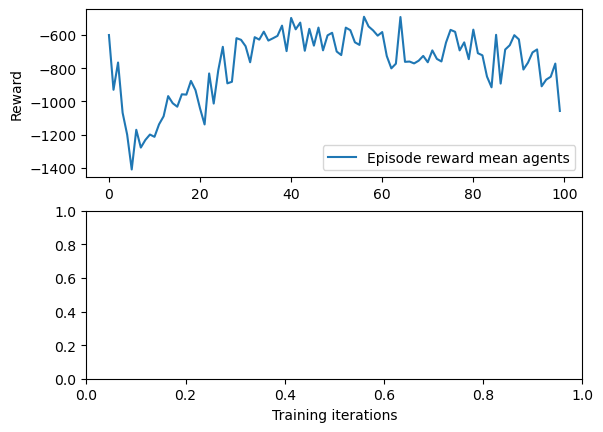

dict_keys(['agents'])


In [76]:
fig, axs = plt.subplots(2, 1)
for i, group in enumerate(env.group_map.keys()):
    axs[i].plot(episode_reward_mean_map[group], label=f"Episode reward mean {group}")
    axs[i].set_ylabel("Reward")
    axs[i].legend()
axs[-1].set_xlabel("Training iterations")
plt.show()
print(env.group_map.keys())